# Code to generate graphics for Data Team section of 12/20/2023 presentation
# Presentation section: 'Censorship and OFAC Status'
#Note: ofac vs. non-ofac boxplot code modified from Tara's code: "blockpending_dist_comparison.ipynb" 

#Code reference date: 12/21/2023

## *Guide to dataframes used in this code
* Tara used Blocknative data to create 'master_finalized_txns.csv.gz'
* 'CAMCOS_2weekdata_readin_forupload.ipynb' uses 'master_finalized_txns.csv.gz' to create 'master_finalized_txns_limited.csv'
* df1: all rows from cleaned limited data ('master_finalized_txns_limited.csv')
* df: blockspending outliers excluded to make graphs more readable
* df10: actualtip outliers excluded to make graphs more readable

In [1]:
import pandas as pd
import numpy as np
#import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path

# Data folder location

#data_folder = ##INSERT DATA FOLDER LOCATION HERE##

#read in TWO WEEK, trimmed and finalized, LIMITED mempool data set

limited_df = data_folder/'master_finalized_txns_limited.csv'
df1 = pd.read_csv(limited_df)


df1 = df1.loc[: , ['basefeepergas', 'maxpriorityfeepergas', 'maxfeepergas', 'timepending', 'blockspending', 'ofac']]
df1.shape

(10176150, 6)

## Create new variables: 
* timepending_: timepending in seconds
* actualtip: tip in wei/gas; tip = min(maxpriorityfee, (maxfeefergas - basefeepergas))
* actualtip_: tip in gwei/gas

In [3]:
## timepending_

df1.loc[:, 'timepending_'] = df1['timepending'] / (1000)
#df1['timepending'].describe()

In [4]:
## actualtip (wei/gas)
# actual tip = min(maxpriorityfee, (maxfeefergas - basefeepergas))
df1.loc[:, 'mfpglessbfpg'] = df1['maxfeepergas'] - df1['basefeepergas']
df1.loc[:, 'actualtip'] = df1[['maxpriorityfeepergas', 'mfpglessbfpg']].min(axis=1)
#df1['weighted_value'] = df1['actualtip'] * df1['blockspending']
df1.shape

(10176150, 9)

In [5]:
df1.actualtip.describe()

count    1.017615e+07
mean     1.513865e+09
std      1.369914e+10
min      0.000000e+00
25%      1.000000e+08
50%      3.000000e+08
75%      2.000000e+09
max      1.998286e+13
Name: actualtip, dtype: float64

In [6]:
## actualtip_ (gwei/gas)
df1.loc[:, 'actualtip_'] = df1['actualtip'] / (10**9)

In [7]:
df1.actualtip_.describe()

count    1.017615e+07
mean     1.513865e+00
std      1.369914e+01
min      0.000000e+00
25%      1.000000e-01
50%      3.000000e-01
75%      2.000000e+00
max      1.998286e+04
Name: actualtip_, dtype: float64

## Create df, dataframe for graphing (exclude blockspending ouliers)

In [8]:
# drop rows where blockspending > 20 bc they are outliers and make the plots hard to read
df = df1[df1['blockspending'] < 20]


## Histograms and boxplots, with relevant summary statistics

### ** OFAC vs. non-OFAC transactions

In [9]:
print("Number of OFAC transactions (for summary stats): ", len(df1[df1['ofac'] == True]))
print("Number of non-OFAC transactions (for summary stats): ", len(df1[df1['ofac'] == False]))

Number of OFAC transactions (for summary stats):  1131
Number of non-OFAC transactions (for summary stats):  10175019


In [10]:
print("Number of OFAC transactions (for graphs): ", len(df[df['ofac'] == True]))
print("Number of non-OFAC transactions (for graphs): ", len(df[df['ofac'] == False]))

Number of OFAC transactions (for graphs):  1120
Number of non-OFAC transactions (for graphs):  10067005


### ** Blockspending

In [11]:
#Describe blockspending (use df1: all txns included)
df1['blockspending'].describe()

count    1.017615e+07
mean     2.933598e+01
std      4.468695e+03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.278693e+06
Name: blockspending, dtype: float64

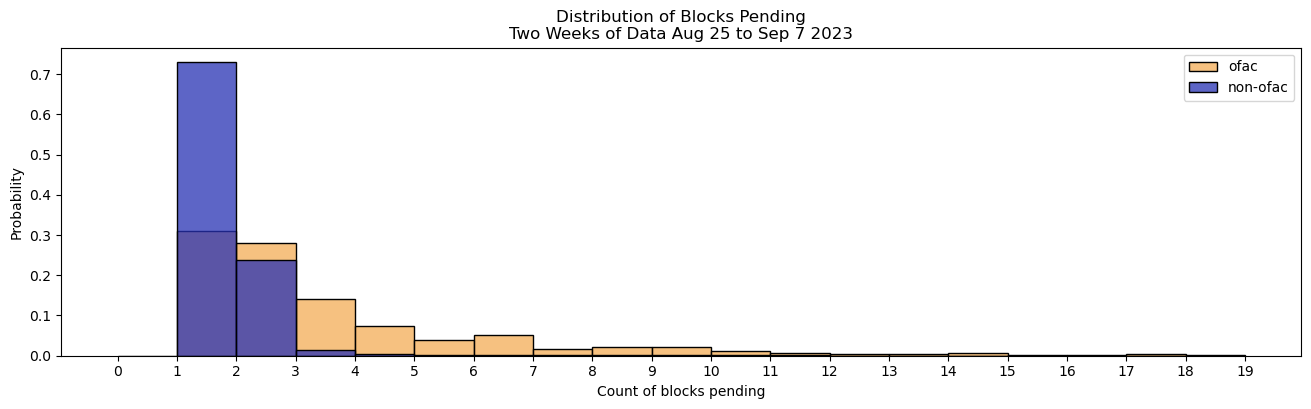

In [12]:
## blockspending histogram (use df to exclude outliers)
## Below: used Tara's posted color palette
#      a strong blue:  #2731b4
#      a soft orange: #f4ad56
## NOTE: for seaborn colorblind palette change these to:
#      a dark blue: #0173b2
#      a vivid orange: #de8f05

from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(16,4))

sns.histplot(data=df[df['ofac']==True], x='blockspending', stat='probability',binwidth=1, color='#f4ad56', 
             edgecolor = 'black', label='ofac')
sns.histplot(data=df[df['ofac']==False], x='blockspending', stat='probability',binwidth=1, color='#2731b4', 
             edgecolor = 'black', label='non-ofac')

#sns.histplot(df[df['ofac']==True]['blockspending'], stat='probability',binwidth=1, edgecolor = 'black')
plt.title('Distribution of Blocks Pending\nTwo Weeks of Data Aug 25 to Sep 7 2023')
plt.xlabel('Count of blocks pending')

plt.xticks(ticks=(np.arange(0, 20, step=1)))  # Set label locations.
plt.legend()
plt.show()

In [13]:
# Describe blockspending for non-OFAC
df1[df1['ofac'] == False]['blockspending'].describe()

count    1.017502e+07
mean     2.933871e+01
std      4.468943e+03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.278693e+06
Name: blockspending, dtype: float64

In [14]:
# Describe blockspending for OFAC
df1[df1['ofac'] == True]['blockspending'].describe()

count    1131.000000
mean        4.821397
std        39.311350
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1302.000000
Name: blockspending, dtype: float64

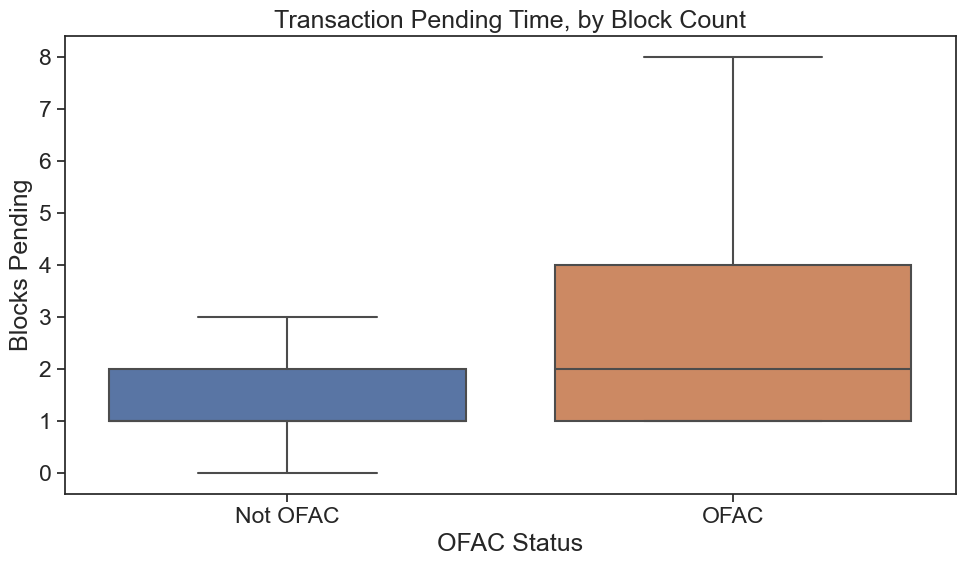

In [15]:
#Boxplot: blockspending, ofac vs. non-ofac
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x='ofac', y='blockspending', data=df, showfliers=False)

# ax.set_yscale('log')
ax.set_xlabel('OFAC Status')
ax.set_ylabel('Blocks Pending')
ax.set_title('Transaction Pending Time, by Block Count')

ax.set_xticklabels(['Not OFAC', 'OFAC'])
plt.tight_layout()
plt.show()
plt.close()
# plt.savefig('pendtime_ofac.png', dpi=300)

## ** Timepending

In [16]:
df1['timepending'].describe()
df1[df1['timepending'] > 15500000000] #unclear why we would see such a high timepending value, ~= to 180 days!

,basefeepergas,maxpriorityfeepergas,maxfeepergas,timepending,blockspending,ofac,timepending_,mfpglessbfpg,actualtip,actualtip_
5016673,2.472826e+10,1.500000e+09,5.438356e+10,1.554235e+10,1278693.0,False,1.554235e+07,2.965530e+10,1.500000e+09,1.5


In [17]:
# Describe timepending_ overall
df1['timepending_'].describe()

count    1.017615e+07
mean     3.484537e+02
std      5.428736e+04
min      1.000000e-03
25%      5.176000e+00
50%      8.460000e+00
75%      1.133600e+01
max      1.554235e+07
Name: timepending_, dtype: float64

In [18]:
# Describe timepending_ for non-OFAC
df1[df1['ofac'] == False]['timepending_'].describe()

count    1.017502e+07
mean     3.484868e+02
std      5.429038e+04
min      1.000000e-03
25%      5.176000e+00
50%      8.460000e+00
75%      1.133500e+01
max      1.554235e+07
Name: timepending_, dtype: float64

In [19]:
# Describe timepending_ for OFAC
df1[df1['ofac'] == True]['timepending_'].describe()

count     1131.000000
mean        51.062008
std        472.628782
min          1.196000
25%          9.390000
50%         19.055000
75%         39.351000
max      15646.431000
Name: timepending_, dtype: float64

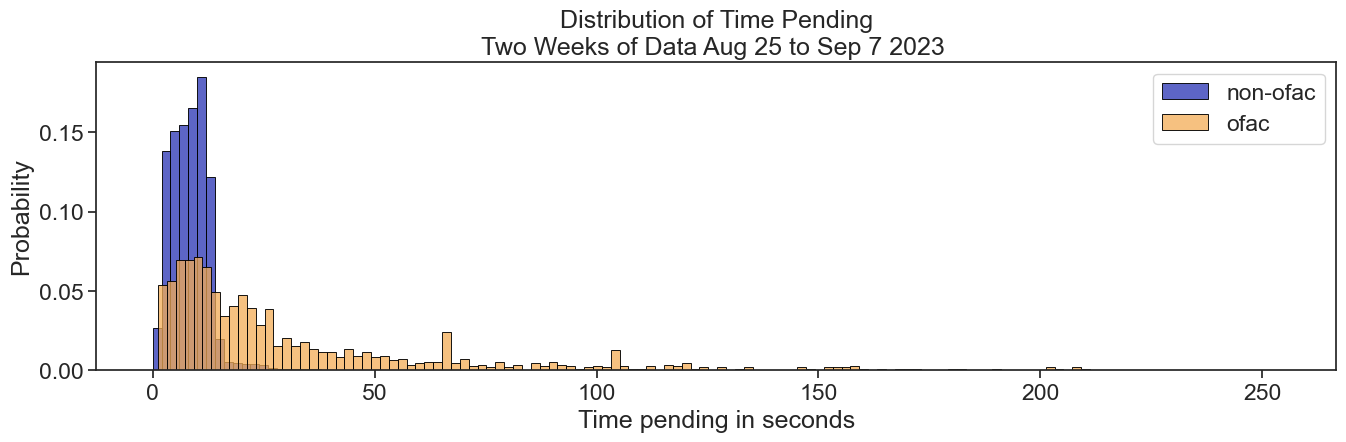

In [21]:
## timepending_ histogram (use df to exclude outliers)
## Below: used Tara's posted color palette
#      a strong blue:  #2731b4
#      a soft orange: #f4ad56
## NOTE: for seaborn colorblind palette change these to:
#      a dark blue: #0173b2
#      a vivid orange: #de8f05

df99 = df[df['timepending_']<50].copy()
plt.figure(figsize=(16,4))

sns.histplot(data=df[df['ofac']==False], binwidth=2,x='timepending_', stat='probability', color='#2731b4', 
             edgecolor = 'black', label='non-ofac')
sns.histplot(data=df[df['ofac']==True], binwidth=2,x='timepending_', stat='probability', color='#f4ad56', 
             edgecolor = 'black', label='ofac')

##sns.histplot(df['timepending_'], bins=100, kde=True, edgecolor = 'black')
plt.title('Distribution of Time Pending\nTwo Weeks of Data Aug 25 to Sep 7 2023 ')
plt.xlabel('Time pending in seconds')
plt.legend()
plt.show()

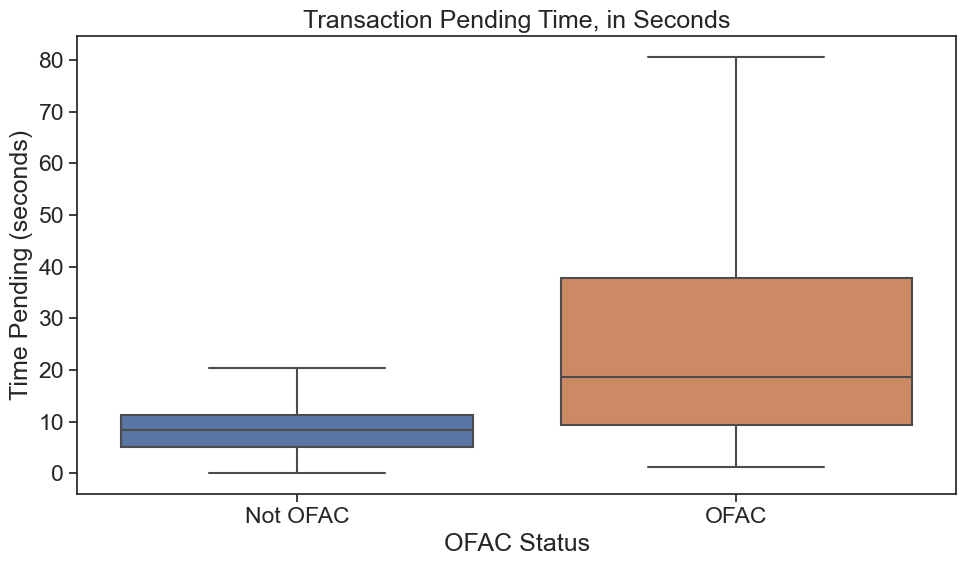

In [22]:
#Boxplot: blockspending, ofac vs. non-ofac
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x='ofac', y='timepending_', data=df, showfliers=False)

# ax.set_yscale('log')
ax.set_xlabel('OFAC Status')
ax.set_ylabel('Time Pending (seconds)')
ax.set_title('Transaction Pending Time, in Seconds')

ax.set_xticklabels(['Not OFAC', 'OFAC'])
plt.tight_layout()
plt.show()
plt.close()
# plt.savefig('pendtime_ofac.png', dpi=300)

## ** Actualtip

In [23]:
# Describe actualtip_ overall
df1['actualtip_'].describe()


count    1.017615e+07
mean     1.513865e+00
std      1.369914e+01
min      0.000000e+00
25%      1.000000e-01
50%      3.000000e-01
75%      2.000000e+00
max      1.998286e+04
Name: actualtip_, dtype: float64

In [24]:
# Describe actualtip_ for non-OFAC
df1[df1['ofac'] == False]['actualtip_'].describe()


count    1.017502e+07
mean     1.513777e+00
std      1.369989e+01
min      0.000000e+00
25%      1.000000e-01
50%      3.000000e-01
75%      2.000000e+00
max      1.998286e+04
Name: actualtip_, dtype: float64

In [25]:
# Describe actualtip_ for OFAC
df1[df1['ofac'] == True]['actualtip_'].describe()

count    1131.000000
mean        2.302713
std         0.975144
min         0.022236
25%         2.000000
50%         3.000000
75%         3.000000
max        10.100000
Name: actualtip_, dtype: float64

In [26]:
#For graphing: only include up to 99th percentile

my99 = np.percentile(df1['actualtip_'], 99)

df10 = df1[df1['actualtip_'] < my99]
my99

12.0

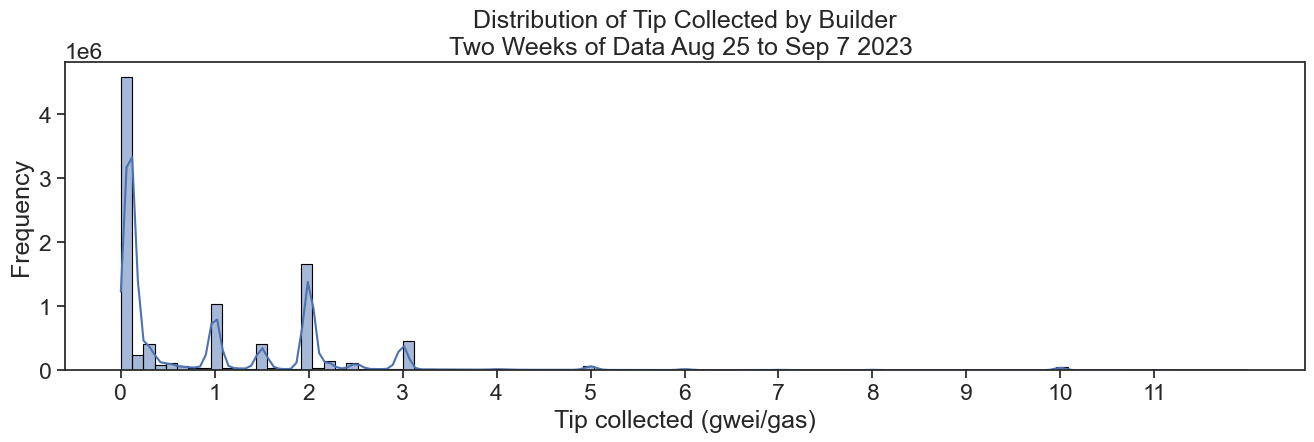

In [27]:
#Histogram
#Plot of actualtip_ that does not include the top 1%
plt.figure(figsize=(16,4))
sns.histplot(df10['actualtip_'], bins=100, kde=True, edgecolor = 'black')
plt.title('Distribution of Tip Collected by Builder\nTwo Weeks of Data Aug 25 to Sep 7 2023 ')
plt.xlabel('Tip collected (gwei/gas)')
plt.ylabel('Frequency')
plt.xticks(ticks=(np.arange(0, my99, step=1)))  # Set label locations.
plt.show()

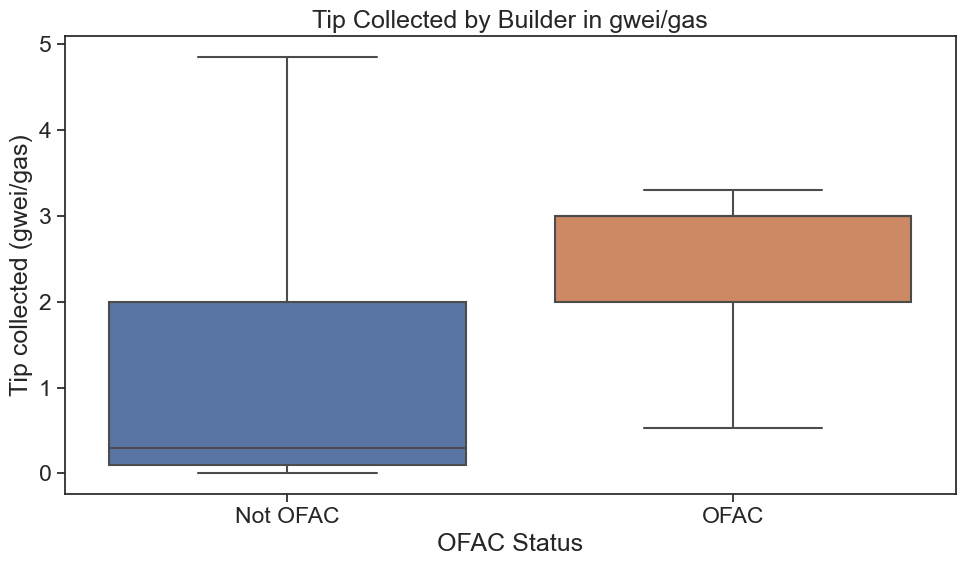

In [28]:
#Boxplot: actualtip_, ofac vs. non-ofac (Use df10 to avoid actualtip outliers)
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x='ofac', y='actualtip_', data=df10, showfliers=False)

# ax.set_yscale('log')
ax.set_xlabel('OFAC Status')
ax.set_ylabel('Tip collected (gwei/gas)')
ax.set_title('Tip Collected by Builder in gwei/gas')

ax.set_xticklabels(['Not OFAC', 'OFAC'])
plt.tight_layout()
plt.show()
plt.close()
# plt.savefig('pendtime_ofac.png', dpi=300)

### Scatterplot: actual tip vs. time pending


## Create index list of all OFAC txns

In [29]:
index_list1 = df1[df1['ofac'] == True].index.values.tolist()
len(index_list1)

1131

## Index list of randomly sampled non-OFAC txns

In [30]:
index_list2 = df1[df1['ofac'] == False].index.values.tolist()

#array of all non-ofac transactions
my_array = np.asarray(index_list2)

#Randomly select from this array
#size of random sample
#my_n = 100000 #This runs, but this many dots makes a big blob
my_n = 10000 ##this works

#set seed
# NOTE: modify seed to take a different sample
np.random.seed(1143)
my_array2 = my_array[np.random.choice(my_array.shape[0], size = my_n, replace=False) ]
#my_array2

#Convert back to list
index_list2a = list(my_array2)
#index_list2a

#Append two lists together: this is the indices of all ofac txns + sample of non-ofac txns
index_master = index_list1 + index_list2a
#index_master

 

## New dataframe with all OFAC, random sample of non-OFAC txns

In [31]:
#New dataframe with all ofac txns, random sample of non-OFAC txns (10 columns/variables in all)
#del df_new
df_new = df1[df1.index.isin(index_master)]
df_new.shape

(11131, 10)

In [32]:
df_new.columns

Index(['basefeepergas', 'maxpriorityfeepergas', 'maxfeepergas', 'timepending',
       'blockspending', 'ofac', 'timepending_', 'mfpglessbfpg', 'actualtip',
       'actualtip_'],
      dtype='object')

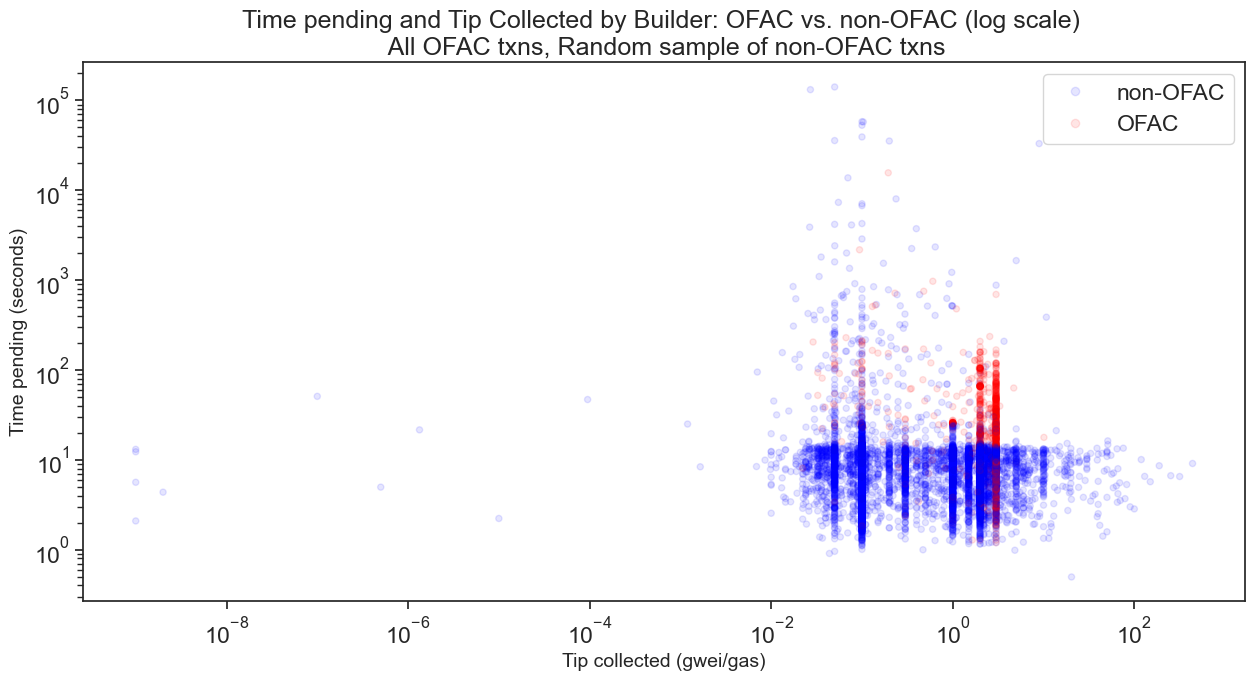

In [36]:
from matplotlib.colors import ListedColormap

fig = plt.figure()
ax = plt.gca()

classes = ['non-OFAC', 'OFAC']
colors = ListedColormap(['blue', 'red'])

##NOTE: other color schemes considered
#https://matplotlib.org/stable/gallery/color/named_colors.html
#other options seemed either too muted, or still did not improve match presentation color scheme
#Example:
#colors = ListedColormap(['mediumblue', 'orangered'])

scatter = ax.scatter(df_new.actualtip_, df_new.timepending_, s=20, c=df_new.ofac, cmap = colors, alpha=0.1)

ax.set_yscale('log')
ax.set_xscale('log')
plt.title("Time pending and Tip Collected by Builder: OFAC vs. non-OFAC (log scale) \n All OFAC txns, Random sample of non-OFAC txns")
plt.xlabel('Tip collected (gwei/gas)', fontsize = 14)
plt.ylabel('Time pending (seconds)', fontsize = 14)

#add legend
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

#Make figure wider
plt.rc('figure', figsize=(15,7))

In [37]:
#Define actualtip_ and timepending_ outliers for zoomed in scatterplot

#Defined earlier in code: 99th percentile of actual tip in full data sample
#my99 = np.percentile(df1['actualtip_'], 99)
my99

my99_timepending_ = np.percentile(df1['timepending_'], 99)
my99_timepending_

print("timepending_ 99th percentile: ", my99_timepending_)
print("atualtip_ 99th percentile: ", my99)


timepending_ 99th percentile:  252.91754999999887
atualtip_ 99th percentile:  12.0


In [38]:
#Limited dataframe: only include the bottom 99th percentile for actualtip and timepending_
df99 = df_new[(df_new['actualtip_'] < my99) & (df_new['timepending_'] < my99_timepending_) ]

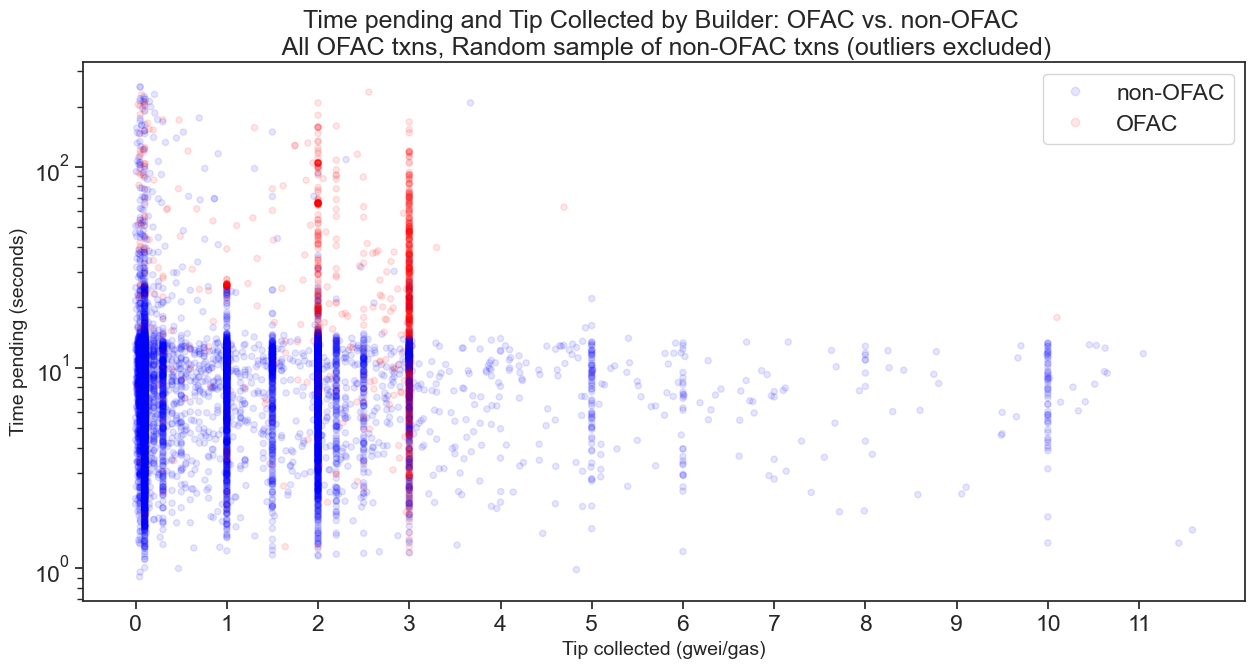

In [39]:
#Zoomed in scatterplot for time vs. tip
#Exclude outliers (99th percentile), and change scale of x-axis
from matplotlib.colors import ListedColormap

fig = plt.figure()
ax = plt.gca()

classes = ['non-OFAC', 'OFAC']
colors = ListedColormap(['blue', 'red'])

scatter = ax.scatter(df99.actualtip_, df99.timepending_, s=20, c=df99.ofac, cmap = colors, alpha=0.1)

ax.set_yscale('log')
#ax.set_xscale('log')
plt.title("Time pending and Tip Collected by Builder: OFAC vs. non-OFAC \n All OFAC txns, Random sample of non-OFAC txns (outliers excluded)")
plt.xlabel('Tip collected (gwei/gas)', fontsize = 14)
plt.ylabel('Time pending (seconds)', fontsize = 14)
plt.xticks(ticks=(np.arange(0, my99, step=1)))  # Set label locations.

#add legend
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

#Make figure wider
plt.rc('figure', figsize=(12,7))

In [40]:
#Reset to default figure size
plt.style.use('default') 

In [41]:
fig_size = plt.rcParams.get('figure.figsize')
fig_size

[6.4, 4.8]